# PROJECT EECS 4404

Preprocessing 

**Feature selection**

**Feature extraction**

In [1]:
# %pip install xgboost
# %pip install lightgbm
# %pip install imbalanced-learn

In [90]:

# Data Manipulation
import numpy as np 
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt

# Machine Learning
from   sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from   sklearn.model_selection import train_test_split, GridSearchCV
from   sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, RocCurveDisplay
from   sklearn.linear_model import LogisticRegression
from   sklearn.tree import DecisionTreeClassifier
from   sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from   sklearn.neighbors import KNeighborsClassifier
from   xgboost import XGBClassifier
from   lightgbm import LGBMClassifier
from   imblearn.over_sampling import RandomOverSampler
from   sklearn.feature_selection import SelectKBest, f_classif, RFECV
from   sklearn.neural_network import MLPClassifier

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
import keras.backend as K

input_file_name = 'datasets.csv'
input_target_class = 'Pos'
nba_players = label = features = X = Y = None
encoder = OneHotEncoder()


def visualizeData(nba_players):
    ### no null values
    nba_players.info()  
    ## metrics
    print(nba_players.groupby(input_target_class).mean())
    # count of the values to make sure it was relatively balanced
    print(nba_players[input_target_class].value_counts())

def dropColumns(players, features):
    ## drop some irrevelant features
    players.drop(features, axis=1, inplace=True)
 


In [78]:
## dropped the double labels because very low count we can try to come up with a solution
nba_players = pd.read_csv(input_file_name).replace({"C-PF": "C", "PG-SG": "PG", "PF-SF": "PF", "PF-C": "PF", "SF-SG": "SF", "SF-PG": "SF", "PF-C": "PF", "SG-SF": "SG", "SG-PG": "SG", "SG-PF": "SG", "SF-C": "SF", "SG-SF": "SG", "SG-PG-SF": "SG", "SF-PF": "SF"})
nba_players.drop_duplicates(inplace=True)
dropColumns(nba_players, {'Age','Player','Tm'})
features = list(nba_players.columns.delete(0))

for i in nba_players.columns[nba_players.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
   nba_players[i].fillna(nba_players[i].mean(),inplace=True)


x = nba_players[features].values
y = nba_players[input_target_class].values
y = encoder.fit_transform(np.reshape(y, (-1, 1))).toarray()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.18, random_state=42)
min_max_scaler = MinMaxScaler().fit(X_train)  # why i picked MinMax https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
X_train, X_test = min_max_scaler.transform(X_train), min_max_scaler.transform(X_test)

X_train.shape


(8384, 25)

In [79]:
visualizeData(nba_players)
dropColumns(nba_players, 'Pos') 
nba_players.skew()

<class 'pandas.core.frame.DataFrame'>
Index: 10225 entries, 0 to 10929
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pos     10225 non-null  object 
 1   G       10225 non-null  int64  
 2   GS      10225 non-null  int64  
 3   MP      10225 non-null  float64
 4   FG      10225 non-null  float64
 5   FGA     10225 non-null  float64
 6   FG%     10225 non-null  float64
 7   3P      10225 non-null  float64
 8   3PA     10225 non-null  float64
 9   3P%     10225 non-null  float64
 10  2P      10225 non-null  float64
 11  2PA     10225 non-null  float64
 12  2P%     10225 non-null  float64
 13  eFG%    10225 non-null  float64
 14  FT      10225 non-null  float64
 15  FTA     10225 non-null  float64
 16  FT%     10225 non-null  float64
 17  ORB     10225 non-null  float64
 18  DRB     10225 non-null  float64
 19  TRB     10225 non-null  float64
 20  AST     10225 non-null  float64
 21  STL     10225 non-null  float64
 22  BLK

G      -0.187648
GS      1.026650
MP      0.195282
FG      1.019119
FGA     0.985997
FG%    -0.404328
3P      1.532725
3PA     1.388053
3P%     0.266945
2P      1.249476
2PA     1.219232
2P%    -0.474138
eFG%   -0.771447
FT      1.803771
FTA     1.741160
FT%    -1.400532
ORB     1.442843
DRB     1.327926
TRB     1.329304
AST     1.914372
STL     1.063932
BLK     2.631412
TOV     1.015960
PF      0.060863
PTS     1.090517
dtype: float64

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   Specs       Score
19   AST  821.921237
16   ORB  814.245804
21   BLK  715.318790
7    3PA  505.496659
18   TRB  453.666779
6     3P  437.076299
17   DRB  277.379792
15   FT%  232.598028
20   STL  204.317234
8    3P%  164.869686


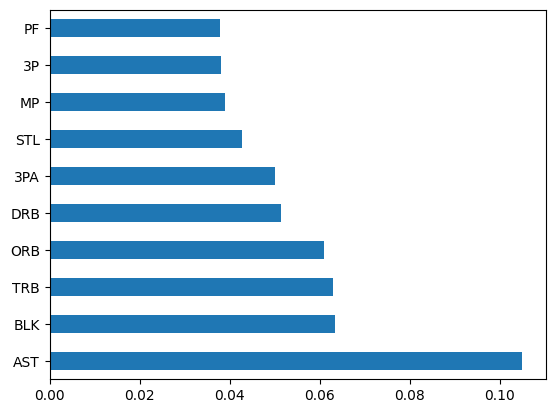

Optimal number of features: 10


In [80]:
topFeatures = 10
selector = SelectKBest(score_func=f_classif, k=topFeatures)  
fit = selector.fit(X_train, encoder.inverse_transform(y_train))

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(topFeatures,'Score'))

model = ExtraTreesClassifier()
model.fit(X_train, y_train)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances.nlargest(topFeatures).plot(kind='barh')
plt.show()

rfc = RandomForestClassifier()
min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=rfc,
    step=1,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

In [84]:
mask = rfecv.get_support()
mask[2] = False
mask[6] = mask[15] = True
best_features = nba_players.columns[mask]
print(best_features)  # choose using rfev selectKbest and featureInportance form classifiers
X_old = X_train
x_test = X_test
X_train = X_train[:,mask]
X_test  = X_test[:,mask]


[False False  True False  True  True False  True False False False False
 False False False False  True  True  True  True False  True False False
  True]
Index(['FGA', 'FG%', '3P', '3PA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'BLK',
       'PTS'],
      dtype='object')


In [93]:
model = DecisionTreeClassifier()
model = model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("The accuracy of prediction is: ", accuracy)

# find number of accurate predictions
accurate_predictions = accuracy_score(y_test, predictions, normalize=False)
print("The number of accurate predictions is: ", accurate_predictions)

model = RandomForestClassifier()
model = model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("The accuracy of prediction is: ", accuracy)

# find number of accurate predictions
accurate_predictions = accuracy_score(y_test, predictions, normalize=False)
print("The number of accurate predictions is: ", accurate_predictions)

model = ExtraTreesClassifier()
model = model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("The accuracy of prediction is: ", accuracy)

# find number of accurate predictions
accurate_predictions = accuracy_score(y_test, predictions, normalize=False)
print("The number of accurate predictions is: ", accurate_predictions)

model  = KNeighborsClassifier()
model = model.fit(X_train, y_train)
accuracy = accuracy_score(y_test, predictions)
print("The accuracy of prediction is: ", accuracy)

# find number of accurate predictions
accurate_predictions = accuracy_score(y_test, predictions, normalize=False)
print("The number of accurate predictions is: ", accurate_predictions)

The accuracy of prediction is:  0.530146659424226
The number of accurate predictions is:  976
The accuracy of prediction is:  0.46387832699619774
The number of accurate predictions is:  854
The accuracy of prediction is:  0.4557305812058664
The number of accurate predictions is:  839
The accuracy of prediction is:  0.4557305812058664
The number of accurate predictions is:  839


In [107]:
#https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
# mlp = MLPClassifier(hidden_layer_sizes=(2,4), activation='tanh', solver='adam', max_iter=15000)
# mlp.fit(X_train,y_train)

# predictions = mlp.predict(X_train)
# # predictions = mlp.predict(X_test)
# accuracy = accuracy_score(y_train, predictions)
# print("The accuracy of prediction is: ", accuracy)

# # find number of accurate predictions
# accurate_predictions = accuracy_score(y_train, predictions, normalize=False)
# print("The number of accurate predictions is: ", accurate_predictions)